# Tensorflow Convnet #

In [1]:
# matplotlib inline command allows us to see right below the code.
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import os
import input_data
import warnings # Ignore dumb warnings about deprecation I'll worry about this when I'm dead
warnings.filterwarnings('ignore')

# Stuff for the plt figures
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print("trX.shape", trX.shape)
print("trY.shape", trY.shape)
print("teX.shape", teX.shape)
print("teY.shape", teY.shape)

trX.shape (55000, 784)
trY.shape (55000, 10)
teX.shape (10000, 784)
teY.shape (10000, 10)


In [4]:
# Turn some into validation: We want 1/5th
FRACTION_VAL = 5

N,D = trX.shape
seq = np.array(range(N))
np.random.shuffle(seq)

X_train = trX[seq[N/FRACTION_VAL:]]
y_train = trY[seq[N/FRACTION_VAL:]]
X_val = trX[seq[:N/FRACTION_VAL]]
y_val = trY[seq[:N/FRACTION_VAL]]

print("X_train.shape" , X_train.shape)
print("X_val.shape" , X_val.shape)
print("y_train.shape" , y_train.shape)
print("y_val.shape" , y_val.shape)

X_train.shape (44000, 784)
X_val.shape (11000, 784)
y_train.shape (44000, 10)
y_val.shape (11000, 10)


Labels, in order:  [8 4 2 1 3 5 2 4 0 4]


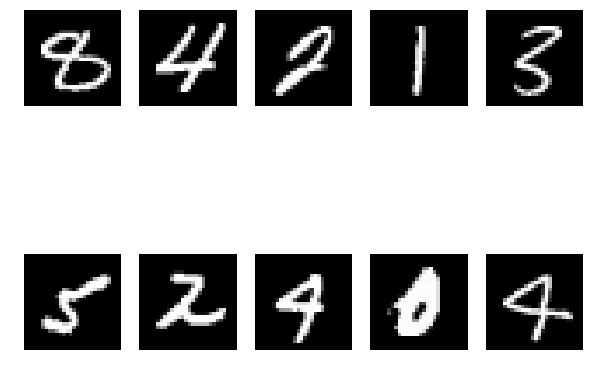

In [5]:
# Let's try to visualize some of these. The format of the images are 28x28.
SHOW_IMAGE = 10

for i in range(SHOW_IMAGE):
    plt.subplot(SHOW_IMAGE/5, SHOW_IMAGE/2, i+1)
    implot = plt.imshow(X_train[i].reshape((28,28)))
    plt.axis('off')

print("Labels, in order: ", np.where(y_train[:i+1] == 1)[-1])

In [14]:
# Now let's build a neural network for this!
# We have the architecture CONV -> RELU -> FC -> RELU -> FC -> SOFTMAX

def init_weight(shape, std = 0.01):
    return tf.Variable(tf.random_normal(shape, std))

def init_model(params):
    X, W0, W1, W2, W3, W4, W5, conv_dropout, fc_dropout = params
    
    ##### STARTING CONV #####
    # First we want to CONV the X to conv_1
    conv_0 = tf.nn.conv2d(X, W0, [1,1,1,1], padding='SAME')
    batch_0 = tf.nn.batch_normalization(drop_0, mean[0], variance[0], offset[0], scale, variance_epsilon, name=None)
    relu_0 = tf.nn.relu(conv_0)
    drop_0 = tf.nn.dropout(relu_0, conv_dropout)
    # Then, we want to CONV the conv_1 to conv_2
    conv_1 = tf.nn.conv2d(drop_0, W1, [1,1,1,1], padding='SAME')
    relu_1 = tf.nn.relu(conv_1)
    drop_1 = tf.nn.dropout(relu_1, conv_dropout)
    
    # Then, we want to POOL the conv_2
    pool_1 = tf.nn.max_pool(relu_1, [1,2,2,1], [1,2,2,1], padding='SAME')
    
    # Then, we want to CONV the pool_2 to conv_3
    conv_2 = tf.nn.conv2d(pool_1, W2, [1,1,1,1], padding='SAME')
    relu_2 = tf.nn.relu(conv_2)
    drop_2 = tf.nn.dropout(relu_2, conv_dropout)

    
    # Then, we want to POOL the conv_3
    pool_2 = tf.nn.max_pool(relu_2, [1,2,2,1], [1,2,2,1], padding='SAME')
    
    # Then, we want to CONV the pool_3
    conv_3 = tf.nn.conv2d(pool_2, W3, [1,1,1,1], padding='SAME')
    relu_3 = tf.nn.relu(conv_3)
    drop_3 = tf.nn.dropout(relu_3, conv_dropout)

    
    ##### STARTING FC #####
    # Then we need to unroll this result and start FC
    fc_3 = tf.reshape(conv_3, [-1, 7*7*64])
    fc_4 = tf.matmul(fc_3, W4)
    relu_4 = tf.nn.relu(fc_4)
    drop_4 = tf.nn.dropout(relu_4, fc_dropout)
    
    # Then we need to fc again to get the result
    fc_5 = tf.matmul(relu_4, W5)
    
    answer = fc_5
    return answer

In [15]:
# Variable is a starting point. tf.random_normal initializes it for us with a stddev
input_shape = X_train.shape
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.float32, [None, 10])

############################# CONVOLUTIONAL LAYER INITIALIZATION #############################
# Each layer is in the form of [NxHxWxC]
# We start off with a layer of [Nx28x28x1]
# We change it to a layer of [Nx28x28x64] from CONV a filter of [3x3], padding 1
# Therefore, we need the weight [filter_height = 3, filter_width = 3, in_channels = 1, out_channels = 64]
W0 = init_weight([3,3,1,64])

# Then, we change it to a layer of [Nx28x28x64] from CONV a filter of [3x3], padding 1
# Therefore, we need the weight [filter_height = 3, filter_width = 3, in_channels = 64, out_channels = 64
W1 = init_weight([3,3,64,64])

# Then, we change it to a layer of [Nx14x14x64] from POOLING with filter of [2x2] with stride 2
# No weights necessary.

# Then, we change it to a layer of [Nx14x14x64] from CONV with a filter of [3x3], padding 1
# Therefore, we need the weight [filter_height = 3, filter_width = 3, in_channels = 64, out_channels = 128]
W2 = init_weight([3,3,64,128])

# Then, we get the layer of [Nx7x7x128] from POOLING with filter of [2x2] with stride 2
# No weights necessary.

# Then, we get the layer of [Nx7x7x64] from CONV with a filter of [3x3], padding 1
# Therefore, we need the weight [filter_height = 3, filter_width = 3, in_channels = 128, out_channels = 64]
W3 = init_weight([3,3,128,64])
################################################################################################

############################# FULLY CONNECTED LAYERS INITIALIZATION #############################
# We need to unroll the parameters of the CONV layer, and we get an input of [Nx(7x7x64)]
W4 = init_weight([7*7*64, 300])

# Then, we do one more FC before we feed into softmax:
W5 = init_weight([300, 10])
################################################################################################

#################################### EXTRA PARAMETERS ####################################
conv_dropout = tf.placeholder(tf.float32)
fc_dropout = tf.placeholder(tf.float32)

In [26]:
# Hyperparams:
learning_rate = 1e-4
reg_rate = 1e-4

hypothesis = init_model((X, W0, W1, W2, W3, W4, W5, conv_dropout, fc_dropout))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(hypothesis, y))

# Regularization 
cross_entropy += reg_rate * (tf.nn.l2_loss(W0)+tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)
                             +tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)+tf.nn.l2_loss(W5))

# Using Adam to optimize
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
predict_op = tf.argmax(hypothesis, 1)

# Let's log it to see our progress!
loss_summary = tf.scalar_summary('loss', cross_entropy)

# Reshape the matrices into the correct conv dimensions:
X_train = X_train.reshape(-1,28,28,1)
X_val = X_val.reshape(-1,28,28,1)
teX = teX.reshape(-1,28,28,1)

In [18]:
# Launch the graph in a session
with tf.Session() as sess:
    #merged = tf.merge_all_summaries([loss_summary])
    writer = tf.train.SummaryWriter('logs', sess.graph_def)
    # you need to initialize all variables
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()

    for i in range(100):
        NUM_BATCHES = 10
        for j in range(NUM_BATCHES):
            batch_mask = np.random.choice(44000, 128)
            summary_str, _, cur_loss = sess.run([loss_summary, train_op, cross_entropy], 
                                                feed_dict={X: X_train[batch_mask], 
                                                           y: y_train[batch_mask],
                                                           conv_dropout: 0.8, 
                                                           fc_dropout: 0.5})

        test_indices = np.arange(len(X_val)) # Get a validation batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:256]

        writer.add_summary(summary_str, i)
        print("Loss : " , cur_loss)
        print(i, np.mean(np.argmax(y_val[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: X_val[test_indices],
                                                         y: y_val[test_indices],
                                                         conv_dropout: 1.0,
                                                         fc_dropout: 1.0})))
        
    save_path = saver.save(sess, "model.ckpt") # checkpoint file
    print("Model saved in file: %s" % save_path)

Loss :  1.24869e+07
0 0.09765625
Loss :  1.07745e+07
1 0.13671875
Loss :  8.54806e+06
2 0.11328125
Loss :  6.9705e+06
3 0.14453125
Loss :  5.64172e+06
4 0.12890625
Loss :  5.25852e+06
5 0.1875
Loss :  4.63622e+06
6 0.203125
Loss :  4.17056e+06
7 0.1796875
Loss :  3.45193e+06
8 0.26171875
Loss :  3.39095e+06
9 0.2734375
Loss :  2.8567e+06
10 0.2734375
Loss :  2.87599e+06
11 0.3828125
Loss :  2.91606e+06
12 0.3984375
Loss :  2.32616e+06
13 0.39453125
Loss :  2.19092e+06
14 0.43359375
Loss :  2.223e+06
15 0.4453125
Loss :  1.94056e+06
16 0.47265625
Loss :  2.4266e+06
17 0.5078125
Loss :  2.23955e+06
18 0.4609375
Loss :  1.79095e+06
19 0.546875
Loss :  1.33303e+06
20 0.55859375
Loss :  1.40051e+06
21 0.4765625
Loss :  1.29897e+06
22 0.62890625
Loss :  1.40351e+06
23 0.5390625
Loss :  1.82460e+06
24 0.5625
Loss :  1.47272e+06
25 0.58203125
Loss :  1.58832e+06
26 0.6171875
Loss :  1.05445e+06
27 0.65234375
Loss :  1.6348e+06
28 0.68359375
Loss :  1.662e+06
29 0.6328125
Loss :  1.40786e+06
30

Answers :  [7 2 1 0 4 1 7 9 5 9]


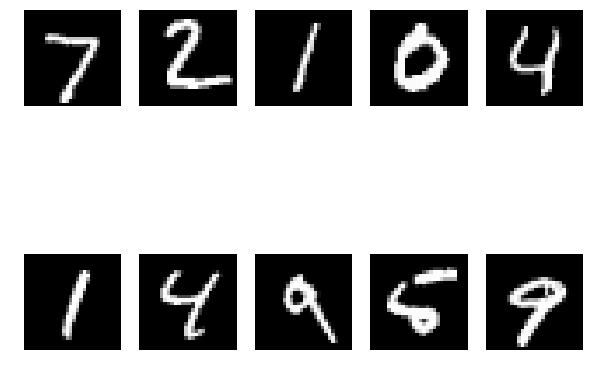

In [30]:
with tf.Session() as sess:
    saver.restore(sess, "model.ckpt")
    answers = sess.run(predict_op, feed_dict={X: teX[:SHOW_IMAGE],
                                     y: teY[:SHOW_IMAGE],
                                     conv_dropout: 1.0,
                                     fc_dropout: 1.0})
    for i in range(SHOW_IMAGE):
        plt.subplot(SHOW_IMAGE/5, SHOW_IMAGE/2, i+1)
        implot = plt.imshow(teX[i].reshape((28,28)))
        plt.axis('off')
    print("Answers : ", answers)